# Unitary Quantum Dynamics with Neural networks
Filippo Vicentini

7 December 2021


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/NetKet-lectures/blob/master/02_unitary_dynamics.ipynb)



We want to solve the Schroedinger's equation of motion given an initial state $\psi(t_0)$

$$
\frac{d\vert\psi(t)\rangle}{dt} = -i\hat{H}\vert\psi(t)\rangle
$$

To avoid the lengthy derivation of the Time-Dependent Variational-Principle (TDVP) we
recall that the variational reformulation of imaginary time evolution, given by the ODE:

$$
\frac{d\vert\psi(t)\rangle}{d\tau} = \hat{H}\vert\psi(t)\rangle
$$
where the real time has been replaced by $\tau=it$, is given by the Stochastic-Reconfiguration
method, where the update of the variational parameters is given by the solution to the
linear system
$$
\Delta W = -d\tau S^{-1} \vec{F}
$$

where $\Delta W$ are the updates during a timestep of the parameters $W$, and where the gradient is:
$$
\vec{F^j} = \langle O^j E^\text{loc}\rangle = \frac{1}{N}\sum_\sigma^N \left(O^{\star i}(\sigma)O^j(\sigma) - \langle O^j\rangle\right) \left(E^\text{loc}(\sigma) - \langle E^\text{loc} \rangle \right)
$$
And the S matrix is:
$$
\langle S_i^j \rangle = \frac{1}{N}\sum_\sigma^N \left(O^i(\sigma) - \langle O^i \rangle\right)^\star\left(O^j(\sigma) - \langle O^i \rangle\right)
$$

Therefore, it is possible to show that the TDVP requires the solution of the equation

$$
\Delta W = -iS\vec{F}
$$

Netket, unfortunately, does not support this out of the box, but we can't write it
ourselves quite easily

## Setting up the initial state
The ansatz we want to work with is the Neural Quantum State, or Restricted Boltzmann
Machine ansatz that we have first seen yesterday.
$$
\log\psi(\sigma^1, \sigma^2, \dots, \sigma^L) = \sum_i\log\cosh\left(\sum_jW^{(i)}_j\sigma^j  + b^j\right)
$$
Notice that if the parameters $\{W,b\}$ are real-valued, then $\log\psi$will be real valued, and if they
are complex-valued, the wavefunction will be complex-valued.

Yesterday we were working with real parameters, that is, $W^i_j\in\mathbb{R}$ and $b^j\in mathbb{R}.
That was legit because the Hamiltonian of the Transverse-Ising model is real, so
we knew that we groundstate wavefunction would have been real.

However, today we want to time-evolve the system. So we must give the ansatz the
freedom to represent any possible state. Therefore we need to use complex-valued
parameters.

We now need to define the initial state.
If you just initialise a Neural-Quantum-State with random parameters, you will have
a very random state.

Therefore, in order to have a physically-interesting state, we will use the variational optimisation
described yesterday in order to find the ground state of a certain hamiltonian.
When this state has been found, we will move forward to time-integrating the Schroedinger's equation.

Notice that we will be optimising the state at $g=0.5$ this time, which
we expect to be much easier to optimise.



In [1]:
# First, let's make sure to run on CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"


First, we want to setup our system and the variational state on it

In [2]:
import netket as nk

# Define the lattice: Chains of 12 sites with PBC
graph = nk.graph.Hypercube(12, n_dim=1, pbc=True)

# Define the hilbert space of wavefunction son this lattice
hilb = nk.hilbert.Spin(1/2, N=graph.n_nodes)

# define the Neural Network ånsatz
machine = nk.models.RBM(alpha=1, dtype=complex)

# define the MC sampler
sampler = nk.sampler.MetropolisLocal(hilb, n_chains=16, n_sweeps=graph.n_nodes)

# Construct the variational Monte Carlo state by combining the sampler and the neural
# network ansatz. We also specify a few options for the sampler.
vs = nk.vqs.MCState(sampler, machine, n_samples=3008, n_discard_per_chain=50)

The state we initialised has random parameters (so it's a random wavefunction, most likely pretty flat).
Since the hilbert space is small enough, we can plot it!

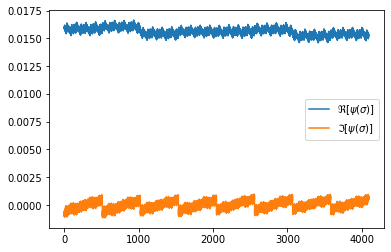

In [3]:
from matplotlib import pyplot as plt

plt.plot(vs.to_array().real, label="$\Re[\psi(\sigma)]$")
plt.plot(vs.to_array().imag, label="$\Im[\psi(\sigma)]$")
plt.legend()

But we want to start from a specific state.
As we don't know which parameters correspond to the state that we want, but we do know that a specific hamiltonian has the state we want as ground state, we can run a ground-state optimisation to find the good parameters.

For the Ground-state optimisation we take the TFIM model with $h=0.5$, and we use Natural Gradient descent (or Stochastic Reconfiguration, as it's known in VMC literature).

In [4]:
from netket.operator.spin import sigmax

# Define the Hamiltonian
H = nk.operator.Ising(hilb, graph=graph, h=0.5, J=1.0)

# Define an observable
Mx = (1/graph.n_nodes) * sum([sigmax(hilb, i) for i in graph.nodes()])

# The optimiser
op = nk.optimizer.Sgd(learning_rate=0.05)

# preconditioner for the optimiser (induces imaginary time evolution)
sr = nk.optimizer.SR(diag_shift=0.001)

# Create the optimization driver
gs = nk.VMC(H, op, preconditioner=sr, variational_state=vs)

logger = nk.logging.JsonLog("data/rbm1_sr_05")
                            
# Run 300 steps of SR optimisation, computing Mx observable
gs.run(300, out=logger, obs={'Mx': Mx}, show_progress=True)

# We store the parameters at the end of the optimisation
W_gs = vs.parameters

100%|██████████| 300/300 [00:54<00:00,  5.50it/s, Energy=-12.76261-0.00007j ± 0.00059 [σ²=0.00105, R̂=0.9993]]



We first check that the optimisation was succesfull


Text(0, 0.5, 'Energy $\\langle E \\rangle$')

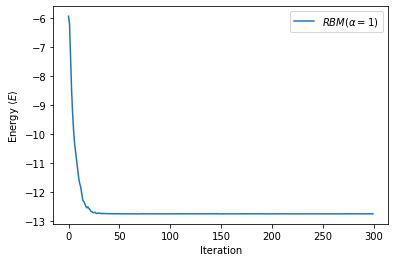

In [5]:
import matplotlib.pyplot as plt

# Store the output into a variable
res_MF = logger.data

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(res_MF['Energy']['iters'], res_MF['Energy']['Mean'].real, label=r'$RBM(\alpha=1)$')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'Energy $\langle E \rangle$')

We can also plot the magnetisation along the x direction

Text(0, 0.5, 'Magnetization $\\langle S_x \\rangle$')

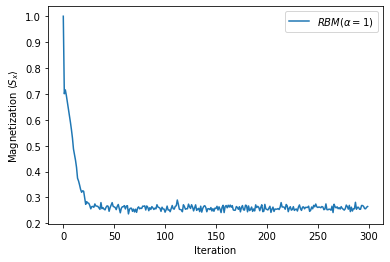

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(res_MF['Mx'].iters, res_MF['Mx'].Mean.real, label=r'$RBM(\alpha=1)$')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'Magnetization $\langle S_x \rangle$')

## Time evolution

First, we generate some 'exact' data using QuTiP

In [7]:
# We build the new quenched hamiltonian, with g=1.0, under which the system evolves dynamically
Ham_quench = nk.operator.Ising(hilb, graph=graph, h=1.0, J=1.0)

# We get the initial state and Hamiltonian in qutip-format
psi_gs_qutip = vs.to_qobj()
Ham_quench_qutip = Ham_quench.to_qobj()
Mx_qutip = Mx.to_qobj()

Text(0, 0.5, 'Magnetization')

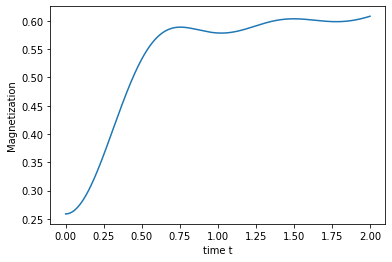

In [8]:
# we import qutip and use it to do the time-evolution
import qutip as qt
import numpy as np

# I define all time-points I will be passing through
tvals_exact = np.arange(0.0, 2.0, 0.001)

# I use the Schroedinger's equation solver to integrate the Schroedinger's equation
# with initial state psi_gs, computing Mx along the time evolution
sol = qt.sesolve(Ham_quench_qutip, psi_gs_qutip, tvals_exact, e_ops=[Mx_qutip])

# I plot Mx
plt.plot(sol.times, sol.expect[0])
plt.xlabel('time t')
plt.ylabel('Magnetization')

We now want to perform the full fledged time evolution with VMC

First, we need to define the code to compute the timestep.
The things to do are the following:

 - Estimate the energy, and it's gradient F
   - We need to sample the wavefunction first, but that's done automatically by NetKet
 - Compute the S matrix
   - Also done automatically by netket. We call it QGT, or Quantum Geometric Tensor, and you can easily access it.
 - solve the syste $\Delta W = -i S \vec{F}$

So we define a function named `timestep` which takes as inputs:
 - The variational state
 - The hamiltonian generating the time-evolution



In [9]:
from jax import tree_map

def timestep(vstate, hamiltonian, *, diag_shift=1e-4):
    # Then we compute ⟨E⟩ and F=∇⟨E⟩
    E, F = vstate.expect_and_grad(hamiltonian)

    # We multiply every element of the gradient by -1.0j
    mF = tree_map(lambda x: -1.0j * x, F)
    
    # We compute the QGT (or S matrix) of our state
    S = vstate.quantum_geometric_tensor()
    
    # We add a diagonal shift to the QGT
    # this is added only to the diagonal.
    S = S + diag_shift
    
    # We solve the linear system
    dW, _ = S.solve(jax.scipy.sparse.linalg.cg, mF)
    
    return dW

Then, we use this function to perform the actual time evolution


In [10]:
import jax
from tqdm import tqdm

# We first build the new hamiltonian, with g=1.0
Ham_quench = nk.operator.Ising(hilb, graph=graph, h=1.0, J=1.0)

# the timestep
dt = 0.005

# I define some observables to keep track of along the time-evolution
res = {'Sx':[]}

# I define all time-points I will be passing through
tvals = np.arange(0.0, 2.0, dt)

# Set the initial cofniguration
vs.parameters = W_gs

# at every timestep
for t in tqdm(tvals):
    # (Before evolving): compute the observables
    res['Sx'].append(vs.expect(Mx).mean.real)

    # We compute the update of the parameters
    dw = timestep(vs, Ham_quench, diag_shift=1e-4)
    
    # We update the parameters
    vs.parameters = jax.tree_multimap(lambda w, dw: w+dt*dw, vs.parameters, dw)


100%|██████████| 400/400 [02:47<00:00,  2.39it/s]



Having performed the time-evoltion, we plot the data:


Text(0, 0.5, 'Magnetization')

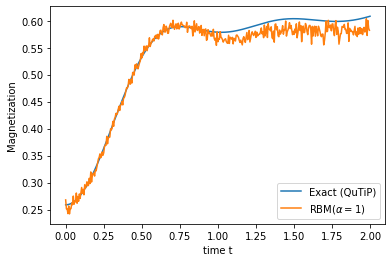

In [11]:
plt.plot(sol.times, sol.expect[0], label='Exact (QuTiP)')
plt.plot(tvals, res['Sx'], label=r"RBM($\alpha=1$)")
plt.legend()
plt.xlabel('time t')
plt.ylabel('Magnetization')

We notice that it does not look too great.

## 3. Increasing the Representation Power

We need to increase the representation power of our neural network to better approximate our state during the time-evolution. 

To do so, we want to change the hidden layer density from 1 to 2, which will approximately double the number of variational parameters.

In [12]:
# define the Neural Network ånsatz
machine2 = nk.models.RBM(alpha=2, dtype=complex)

# Construct a new variational state with the new machine
vs2 = nk.vqs.MCState(sampler, machine2, n_samples=3008, n_discard_per_chain=50)

# Compare the number of parameters
print(f"The RBM(α=1) variational state has {vs.n_parameters} parameters")
print(f"The RBM(α=2) variational state has {vs2.n_parameters} parameters")

The RBM(α=1) variational state has 168 parameters
The RBM(α=2) variational state has 324 parameters


We now need to also optimise the initial state of the new model



In [13]:
# Create the optimization driver
gs = nk.VMC(H, op, preconditioner=sr, variational_state=vs2)
                            
# Run 300 steps of SR optimisation, computing Mx observable
log2 = nk.logging.RuntimeLog()
gs.run(300, out=log2, obs={'Mx': Mx}, show_progress=True)

W_gs2 = vs2.parameters

100%|██████████| 300/300 [01:26<00:00,  3.46it/s, Energy=-12.7616+0.0003j ± 0.0011 [σ²=0.0036, R̂=0.9993]]    


And now that we have the initial parameters of the new ansatz with $\alpha=2$, we need to perform the new time-evolution.

Hopefully, you've already learnt how to write down the TDVP equations above, so we will now showcase the Dynamics driver of NetKet, which essentially integrates the same equatino as the code above does, but is more flexible and comes with a few nice additions.

*NOTE*: This is a new feature of NetKet 3.3 (to be released on december 14). Make sure you have an up to date version with `pip install --upgrade netket` and by checking `netket.__version__`). If you want to run this before december 14, then `pip install 'git+https://github.com/netket/netket.git'`. Otherwise, you can just rerun the same code as above!

In [14]:
from netket import experimental as nkx

# You can pick from many different integrators, with and without adaptive timestepping.
# In this example we chose Euler
integrator = nkx.dynamics.Euler(dt=dt)

# We now construct the TDVP (Time-Dependent-Variational-Principle) driver
# Note: The qgt argument takes an argument that specifies how the Quantum Geometric Tensor (or S matrix) should
# be computed. This is a purely technical detail, but properly chosing the right implementation will give you
# a remarkable speedup! Read more at https://www.netket.org/docs/sr.html
te = nkx.TDVP(
    Ham_quench, # can also be time-dependent
    variational_state=vs2,
    integrator=integrator, # RK-style integrator.
    t0=0.0,     # initial integration time
    qgt=nk.optimizer.qgt.QGTJacobianDense(holomorphic=True, diag_shift=1e-4), # QGT implementation. 
)

# integrate the dynamics
tevo2 = nk.logging.RuntimeLog()
te.run(
    T=tvals[-1], # end time
    out=tevo2,   # logger
    show_progress=True,
    obs={"Sx": Mx},
    tstops=tvals, # at what timesteps should observables be computed
)

res2 = tevo2.data

100%|█████████▉| 1.9949999999999999/1.995 [01:37<00:00, 48.88s/it, Generator=-14.229-0.011j ± 0.040 [σ²=4.089, R̂=1.0015]]  /home/filippovicentini/Documents/pythonenvs/netket_env/lib64/python3.8/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.9999999999999998/1.995 [01:37<00:00, 49.00s/it, Generator=-14.229-0.011j ± 0.040 [σ²=4.089, R̂=1.0015]]


/home/filippovicentini/Documents/pythonenvs/netket_env/lib64/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Magnetization')

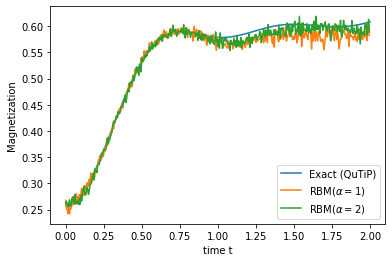

In [15]:
plt.plot(sol.times, sol.expect[0], label='Exact (QuTiP)')
plt.plot(tvals, res['Sx'], label=r"RBM($\alpha=1$)")
plt.plot(tvals, res2['Sx'], label=r"RBM($\alpha=2$)")
plt.legend()
plt.xlabel('time t')
plt.ylabel('Magnetization')

In [ ]:
sampler_obs = nk.sampler.MetropolisLocal(machine=machine.diagonal())


### Putting everything together
If we collate all the things you have seen above, and run the optimisation, we get:



In [ ]:
import netket as nk
import jax

L = 6
H = build_hamiltonian(L=L, g=-0.49/2, J=0.25)
Sx = build_Sx(L=L)
Sy = build_Sy(L=L)
Sz = build_Sz(L=L)

# Generate the list of collapse/jump operators:
jump_ops = []
for i in range(L):
    op = nk.operator.spin.sigmam(H.hilbert, i)
    jump_ops.append(op)

# Construct the Lindblad Super-Operator
lindblad = nk.operator.LocalLiouvillian(H, jump_ops)

# Construct the machine and initialise it's parameters
machine = nk.machine.density_matrix.NdmSpin(hilbert=H.hilbert, alpha=1, beta=2)
machine.init_random_parameters(sigma=0.01, seed=123)

# Sampler for the machine
sampler = nk.sampler.MetropolisLocal(machine, n_chains=16, sweep_size=2*L)
# Sampler of the diagonal of the density matrix, for the observables
sampler_obs = nk.sampler.MetropolisLocal(machine=machine.diagonal())

optimizer = nk.optimizer.Sgd(machine, 0.01)
sr = nk.optimizer.SR(machine, diag_shift=0.001, use_iterative=True)

# Construct the object looking for the steady state
ss = nk.SteadyState(lindblad, sampler, optimizer, n_samples=1000,
                    sampler_obs=sampler_obs, n_samples_obs=500)

# Run the optimisation
ss.run(n_iter=300, out="data/open_ndm12_3", obs={'Sx':Sx, 'Sy': Sy, 'Sz':Sz})




And if we plot the results:



In [ ]:
ss = read_open('data/open_ndm11')

fig, ax = plt.subplots(4)

ax[0].plot(ss['iter'], ss['LdagL'])
ax[0].get_xaxis().set_visible(False)
ax[0].set(ylabel='LdagL')
ax[1].plot(ss['iter'], ss['Sx'])
ax[1].get_xaxis().set_visible(False)
ax[1].set(ylabel='Sx')
ax[2].plot(ss['iter'], ss['Sy'])
ax[2].get_xaxis().set_visible(False)
ax[2].set(ylabel='Sy')
ax[3].plot(ss['iter'], ss['Sz'])
ax[3].set(ylabel='Sz')

plt.legend()
plt.xlabel('Iteration step')
plt.ylabel('Magnetization')